In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps, cumtrapz
import pandas as pd
from scipy import constants

r =  2.6392235755368e-06
temp = 293
rho = 4200
rho_f = 789
eta = 0.36e-3
mass = 4/3 *np.pi *r**3*rho + 2/3 *np.pi *r**3*rho_f

In [57]:
# SIMULATIONS

chunksize = 10 ** 6  # Adjust chunk size based on your memory availability
chunks = []

for chunk in pd.read_csv(r'C:\Users\mcthu\PycharmProjects\MarkovianEmbedding\position_velocity_data.csv', chunksize=chunksize, low_memory=False):
    # process each chunk individually or filter/aggregate it
    chunks.append(chunk)

df = pd.concat(chunks, ignore_index=True)

# Extract only the columns that start with 'Position' or 'Velocity'
position_cols = [col for col in df.columns if col.startswith('Position')]
velocity_cols = [col for col in df.columns if col.startswith('Velocity')]

timestep_sim = df['real_timestep_s'].values[0]
positions_sim = []
velocities_sim = []
for i in range(len(position_cols)):
    positions_sim.append(df[position_cols[i]].astype(float).values)
    velocities_sim.append(df[velocity_cols[i]].astype(float).values)

# print(f"Positions shape: {positions_sim.shape}")
# print(f"Velocities shape: {velocities_sim.shape}")

bin_num_sim = 10
fs_sim = 1/(timestep_sim * bin_num_sim)

def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

traces_sim = []
for trace in positions_sim:
    series = bin_data(trace, bin_num_sim)
    traces_sim.append(series)

print("len of traces is " + str(len(traces_sim)))

v_traces_sim = []
for trace in velocities_sim:
    series = bin_data(trace, bin_num_sim)
    v_traces_sim.append(series)

len of traces is 1


sqrt kT/m is 0.00010692955166955203
vel std is 0.00010643373808415319
length of history is 5062
length of trace is 1600753
speed idx sim: 2077
total hist idx: 2070


C:\Users\mcthu\AppData\Local\Temp\ipykernel_8168\4203649348.py:34: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  total = simps(integrand, t_hist)
C:\Users\mcthu\AppData\Local\Temp\ipykernel_8168\4203649348.py:35: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cumlutive = cumtrapz(integrand, t_hist)


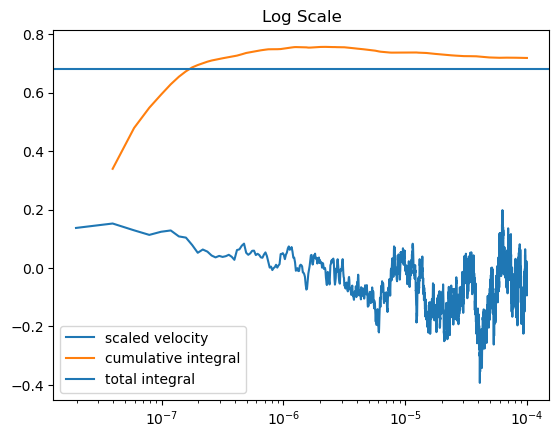

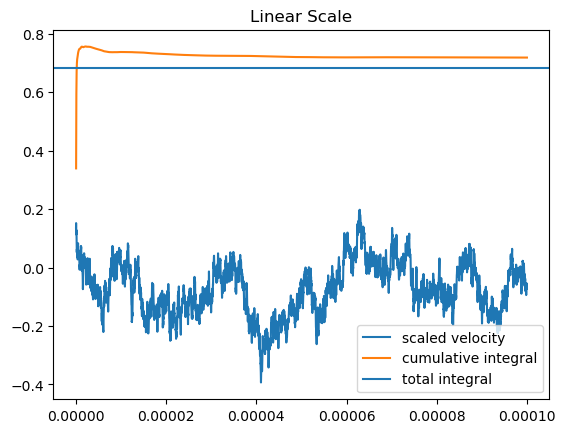

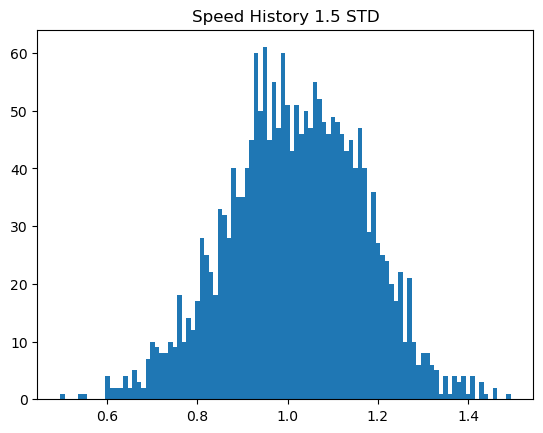

3.947919628251402e-11
5.6747197199068e-17
Ratio is 708545.7578317241
length of history is 5062
length of trace is 1600753
speed idx sim: 5544
total hist idx: 5528


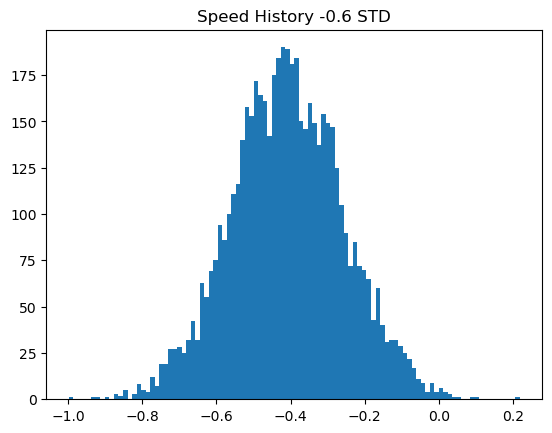

3.947919628251402e-11
-2.26988788796272e-17
Ratio is 710565.4624123775
length of history is 5062
length of trace is 1600753
speed idx sim: 6371
total hist idx: 6350


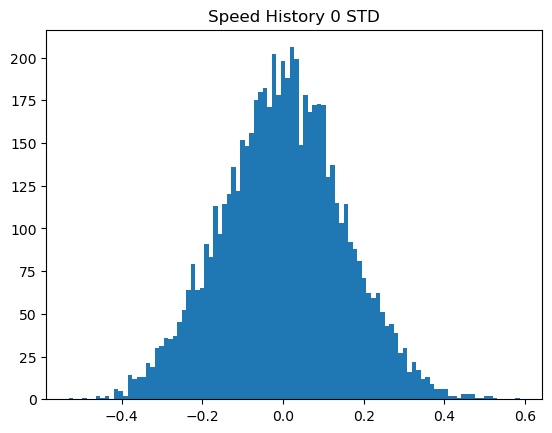

3.947919628251402e-11
0.0
Ratio is -inf
length of history is 5062
length of trace is 1600753
speed idx sim: 5320
total hist idx: 5295


C:\Users\mcthu\AppData\Local\Temp\ipykernel_8168\4203649348.py:60: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = ((mass*v_0)+6*r**2*np.sqrt(np.pi * eta * rho_f)*np.mean(speed_histories))/(mass*v_0)


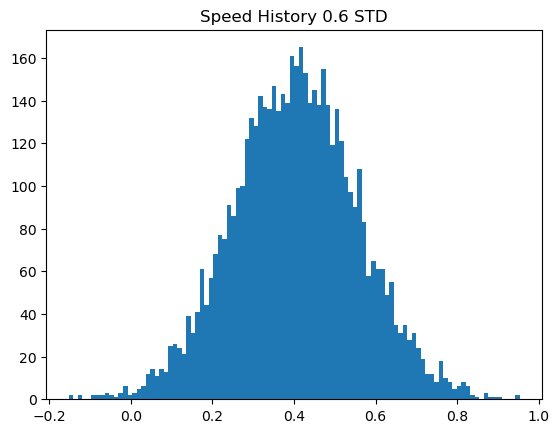

3.947919628251402e-11
2.26988788796272e-17
Ratio is 703105.3454020339
length of history is 5062
length of trace is 1600753
speed idx sim: 2077
total hist idx: 2070


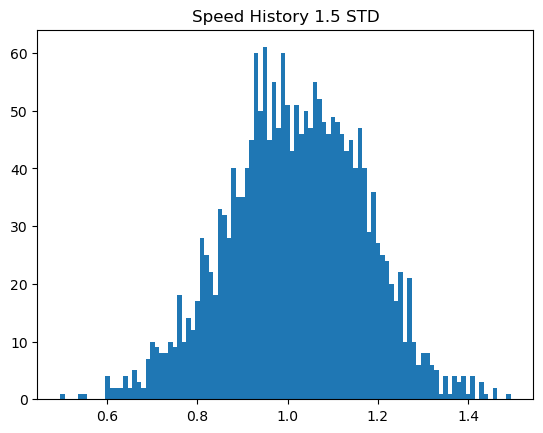

3.947919628251402e-11
5.6747197199068e-17
Ratio is 708545.7578317241


In [58]:
print("sqrt kT/m is " + str(np.sqrt(constants.k*temp/mass)))
print("vel std is " + str(np.std(v_traces_sim[0])))
# SIM PART 2
vos = [1.5, -.6, 0, .6, 1.5]
tol = .005
hist_len = int(10e-5*fs_sim)

sim_histories = []
first = True

# integrand = v / t**(1.5)

for speed in vos:
    print("length of history is " + str(hist_len) )
    print("length of trace is " + str(len(v_traces_sim[0])))
    speed_histories = []
    for i in range(len(traces_sim)):
        v_tolerance = (speed * np.std(v_traces_sim[i]))
        speed_tolerance = tol * np.std(v_traces_sim[i])
        v_indices = np.where((v_traces_sim[i] < v_tolerance + speed_tolerance) & (v_traces_sim[i] > v_tolerance - speed_tolerance))[0]
        print("speed idx sim: " + str(len(v_indices)))

        hist_idx = []
        for idx in v_indices:
            if idx - hist_len > 0: #idx - last_idx > (init_len / 100) and
                hist_idx.append(idx)

        print("total hist idx: " + str(len(hist_idx)))

        for idx in hist_idx:
            v = v_traces_sim[i][idx - hist_len: idx][::-1]
            t_hist = np.arange(1, hist_len + 1)*(1/fs_sim)
            integrand = v / (2*t_hist**(1.5))
            total = simps(integrand, t_hist)
            cumlutive = cumtrapz(integrand, t_hist)
            speed_histories.append(total)
            if first:
                plt.plot(t_hist, v*1000, label = "scaled velocity")
                plt.plot(t_hist[1:], cumlutive, label = "cumulative integral")
                plt.axhline(total, label = "total integral")
                plt.xscale('log')
                plt.legend()
                plt.title("Log Scale")
                plt.show()
                plt.plot(t_hist, v*1000, label = "scaled velocity")
                plt.plot(t_hist[1:], cumlutive, label = "cumulative integral")
                plt.axhline(total, label = "total integral")
                plt.xscale('linear')
                plt.legend()
                plt.title("Linear Scale")
                plt.show()
                first = False
    sim_histories.append(speed_histories)
    plt.hist(speed_histories, 100)
    plt.title(f"Speed History {speed} STD")
    plt.show()
    v_0 = speed*np.sqrt(constants.k*temp/mass)
    print(6*r**2*np.sqrt(np.pi * eta * rho_f))
    print((mass*v_0))
    ratio = ((mass*v_0)+6*r**2*np.sqrt(np.pi * eta * rho_f)*np.mean(speed_histories))/(mass*v_0)
    print("Ratio is " + str(ratio))


In [59]:
# Find Ratio of 6 pi a**2 sqrt(eta rho_f) V to M v_0
print("step is " + str(1/fs_sim))


step is 1.9754935012178623e-08
